In [3]:
# coding: utf-8
import numpy as np
from skimage import io,transform
import matplotlib.pyplot as plt
import math
import tensorflow as tf

(50, 50)
[[0.90909091 0.89090909 0.86363636 ... 0.45454545 0.48181818 0.46363636]
 [0.88181818 0.86363636 0.84545455 ... 0.45454545 0.46363636 0.45454545]
 [0.84545455 0.83636364 0.80909091 ... 0.45454545 0.45454545 0.43636364]
 ...
 [0.56363636 0.55454545 0.53636364 ... 0.46363636 0.41818182 0.4       ]
 [0.53636364 0.54545455 0.55454545 ... 0.42727273 0.42727273 0.39090909]
 [0.61818182 0.63636364 0.64545455 ... 0.43636364 0.37272727 0.33636364]]
(2500,)
(50, 50)


C:\Users\liang\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\liang\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


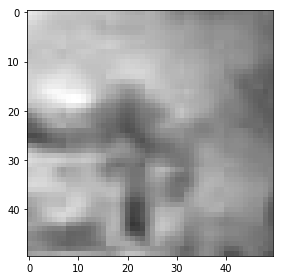

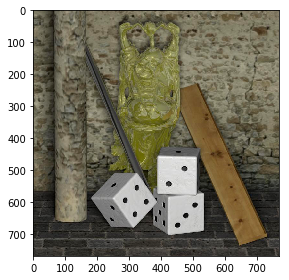

epoch:0 item:0 608.12006
epoch:1 item:0 2.097377
epoch:2 item:0 0.23943292
epoch:3 item:0 0.8820337
Finish
(50, 50)
[[0.23636364 0.18181818 0.15454545 ... 0.73636364 0.75454545 0.78181818]
 [0.25454545 0.19090909 0.16363636 ... 0.70909091 0.72727273 0.74545455]
 [0.28181818 0.23636364 0.20909091 ... 0.69090909 0.69090909 0.7       ]
 ...
 [0.42727273 0.42727273 0.42727273 ... 0.96363636 0.97272727 0.97272727]
 [0.44545455 0.44545455 0.44545455 ... 0.94545455 0.95454545 0.95454545]
 [0.45454545 0.45454545 0.45454545 ... 0.93636364 0.94545455 0.95454545]]
(2500,)
(50, 50)


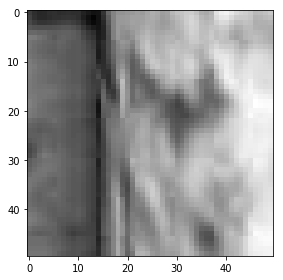

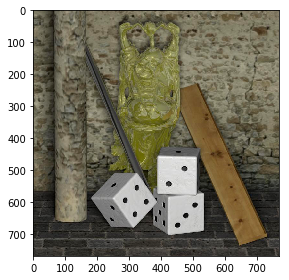

epoch:0 item:0 502.37546
epoch:1 item:0 0.4875188
epoch:2 item:0 1.6630709
epoch:3 item:0 0.39770785
Finish


In [6]:
path="D:/LFGAN+ASR/MODEL/01.jpg"
img_data_tot = io.imread(path)

# s_h=b[0]//cut
# s_w=b[1]//cut 
s_h=50
s_w=50
n=s_h*s_w*1
size=[s_h, s_w,1]#复原图像用
start=0

for iter in range(2):
    start=iter*s_h
    img_data=img_data_tot[start:start+s_h,start:start+s_w,2]
    def per_image_standardization(img):

        img_t=img/np.max(img)
        return img_t
    img_data_tot=per_image_standardization(img_data_tot)
    print(img_data.shape)
    img_data=per_image_standardization(img_data)
    print(img_data)
    X_ph5=img_data.reshape(1,-1)
    #print(X_ph5)
    x = X_ph5[0,:]
    print(x.shape)
    # #真实图像
    # plt.figure("Image_original") # 图像窗口名称
    # plt.imshow(x.reshape(size))
    # plt.axis('on') # 关掉坐标轴为 off
    # plt.title('image_original') # 图像题目
    # plt.show()

    # bdata=x.reshape(size)[:,:,2]
    print(img_data.shape)
    io.imshow(img_data)
    io.show()

    io.imshow(img_data_tot)
    io.show()
    
    
    
    tf.reset_default_graph() 

    #生成高斯随机测量矩阵
    sampleRate=0.5  #采样率
    Phi=np.random.randn(int(n*sampleRate),n) #观测矩阵
    A = tf.cast(Phi,tf.float32)#观测矩阵

    #选Ph5中的一个信号进行复原
    x = X_ph5[0,:]
    im = x.reshape(-1,1)

    #模拟真实观测到的数据
    img_cs_1d_ph5=np.dot(Phi,im)#得到稀疏表示的信号

    # In[15]:
    import tensorflow as tf

    # In[16]:
    Z = np.random.normal(loc=0.0, scale=0.01, size=(n,))
    Z = Z.reshape(-1,n)


    # In[17]:
   
    y_ph5 = img_cs_1d_ph5.reshape(1,-1)


    # In[18]:
    def conv_out_size_same(size,stride):
        return int(math.ceil(float(size) / float(stride)))

    def linear(images, output_size, stddev=0.02, bias_start=0.0, name='Linear'):
            shape = images.get_shape().as_list()

            with tf.variable_scope(name):
                w = tf.get_variable("w", [shape[1], output_size], tf.float32,
                                    tf.random_normal_initializer(stddev=stddev))
                b = tf.get_variable("b", [output_size],
                                    initializer=tf.constant_initializer(bias_start))
                return tf.matmul(images, w) + b, w, b

    def batch_normalizer(x, epsilon=1e-5, momentum=0.9, train=True, name='batch_norm'):
            with tf.variable_scope(name):
                return tf.contrib.layers.batch_norm(x, decay=momentum, updates_collections=None, epsilon=epsilon,
                                                    scale=True, is_training=train)

    def deconv2d(images, output_shape, stddev=0.02, name='deconv2d'):
            with tf.variable_scope(name):
                # filter : [height, width, output_channels, in_channels]
                # 注意与卷积的不同
                filter_shape = [5, 5, output_shape[-1], images.get_shape()[-1]]
                # strides
                # 对应每一维的filter移动步长
                strides_shape = [1, 2, 2, 1]

                w = tf.get_variable('w', filter_shape, initializer=tf.random_normal_initializer(stddev=stddev))
                b = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))

                deconv = tf.nn.conv2d_transpose(images, w, output_shape=output_shape, strides=strides_shape)
                deconv = tf.nn.bias_add(deconv, b)

                return deconv, w, b

    def generator(noise_imgs,train=True):
            with tf.variable_scope('generator'):
                # 分别对应每个layer的height, width
                s_h, s_w, _ = img_shape
                s_h2, s_w2 = conv_out_size_same(s_h, 2), conv_out_size_same(s_w, 2)
                s_h4, s_w4 = conv_out_size_same(s_h2, 2), conv_out_size_same(s_w2, 2)
                s_h8, s_w8 = conv_out_size_same(s_h4, 2), conv_out_size_same(s_w4, 2)
                s_h16, s_w16 = conv_out_size_same(s_h8, 2), conv_out_size_same(s_w8, 2)

                # layer 0
                # 对输入噪音图片进行线性变换
                z, h0_w, h0_b = linear(noise_imgs, gf_size*8*s_h16*s_w16)
                # reshape为合适的输入层格式
                h0 = tf.reshape(z, [-1, s_h16, s_w16, gf_size * 8])
                # 对数据进行归一化处理 加快收敛速度
                h0 = batch_normalizer(h0, train=train, name='g_bn0')
                # 激活函数
                h0 = tf.nn.relu(h0)

                # layer 1
                # 卷积转置进行上采样
                h1, h1_w, h1_b = deconv2d(h0, [batch_size, s_h8, s_w8, gf_size*4], name='g_h1')
                h1 = batch_normalizer(h1, train=train, name='g_bn1')
                h1 = tf.nn.relu(h1)

                # layer 2
                h2, h2_w, h2_b = deconv2d(h1, [batch_size, s_h4, s_w4, gf_size*2], name='g_h2')
                h2 = batch_normalizer(h2, train=train, name='g_bn2')
                h2 = tf.nn.relu(h2)

                # layer 3
                h3, h3_w, h3_b = deconv2d(h2, [batch_size, s_h2, s_w2, gf_size*1], name='g_h3')
                h3 = batch_normalizer(h3, train=train, name='g_bn3')
                h3 = tf.nn.relu(h3)

                # layer 4
                h4, h4_w, h4_b = deconv2d(h3, batch_shape, name='g_h4')
                return tf.nn.relu(h4)

    def optimizer_graph(gen_loss, learning_rate,beta1):
            # 所有定义变量
            train_vars = tf.trainable_variables()
            # 生成器变量
            gen_vars = [var for var in train_vars if var.name.startswith('generator')]
            # optimizer
            # 生成器网络需要优化
            gen_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(gen_loss, var_list=gen_vars)
            return gen_optimizer


    # In[19]:
    # 真实图片shape (height, width, depth)
    img_shape = (n,1,1)
    # 一个batch包含图片数量
    batch_size = 1
    # 一个batch的图片向量shape (batch, height, width, depth)
    batch_shape = (batch_size, ) + img_shape
    # batch数量
    chunk_size = 2000 // 1

    # 噪音图片size
    noise_img_size = X_ph5.shape[1]
    # 卷积转置输出通道数量
    gf_size = 64
    # 训练循环次数
    epoch_size = 50
    # 学习率
    learning_rate = 0.001
    beta1 = 0.5

    y = tf.placeholder(tf.float32,[y_ph5.shape[1],None])
    noise_imgs = tf.placeholder(tf.float32, [None, noise_img_size], name='noise_imgs')
    # 生成器图片
    fake_imgs = generator(noise_imgs)


    # In[20]:
    #损失
    gen_loss = tf.reduce_mean(tf.square(y-tf.matmul(A,fake_imgs[0][:,:,0])))
    #优化
    gen_optimizer = optimizer_graph(gen_loss, learning_rate, beta1)


    # In[21]:
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        for epoch in range(4):
            for i in range(100):#不能将batchsize设置的太大，否则会跑不起来，1000也是可以的
     
                sess.run(gen_optimizer,feed_dict={noise_imgs:Z,y:y_ph5.reshape(-1,1)})  
                if i%100==0:
                   
                    pred_ph5 = sess.run(fake_imgs[0][:,:,0],feed_dict={noise_imgs:Z,y:y_ph5.reshape(-1,1)})
                    print("epoch:%d item:%d"%(epoch, i), sess.run(gen_loss,feed_dict={noise_imgs:Z,y:y_ph5.reshape(-1,1)}))
    print("Finish")






In [60]:
    if iter == 0:
        d = pred_ph5.reshape(size)
    else:
        d = np.hstack((pred_ph5, d))
    # if iter%5==0:
    io.imshow(d)
    io.show()


(50, 50)


C:\Users\liang\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\liang\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


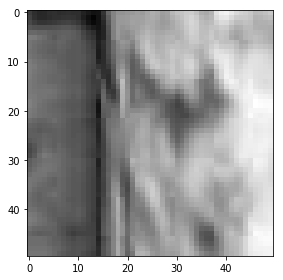

[[0.23636364 0.18181818 0.15454545 ... 0.73636364 0.75454545 0.78181818]
 [0.25454545 0.19090909 0.16363636 ... 0.70909091 0.72727273 0.74545455]
 [0.28181818 0.23636364 0.20909091 ... 0.69090909 0.69090909 0.7       ]
 ...
 [0.42727273 0.42727273 0.42727273 ... 0.96363636 0.97272727 0.97272727]
 [0.44545455 0.44545455 0.44545455 ... 0.94545455 0.95454545 0.95454545]
 [0.45454545 0.45454545 0.45454545 ... 0.93636364 0.94545455 0.95454545]]
[[0.10707173 0.11745187 0.35109624 ... 0.81495523 0.57003963 0.43443355]
 [0.         0.         0.03069058 ... 0.78132653 0.         0.03179672]
 [0.38964233 0.         0.32105508 ... 0.8541081  0.81035674 0.        ]
 ...
 [0.18117423 0.35948834 0.         ... 0.         0.70452726 0.62353444]
 [0.82783264 0.4612796  0.03951871 ... 0.49419254 0.         0.        ]
 [0.5602294  0.38944343 0.40142307 ... 0.341059   0.36900166 0.7067887 ]]
[[ 0.12929191  0.06436631 -0.19655079 ... -0.0785916   0.18450582
   0.34738463]
 [ 0.25454545  0.19090909  0.13

C:\Users\liang\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


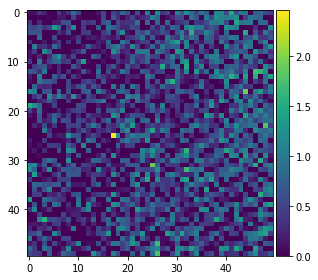

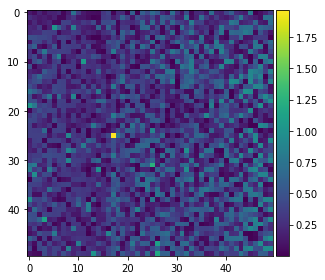

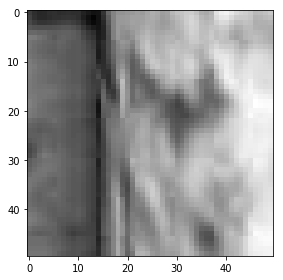

In [8]:
size=[s_h, s_w]
min_pre=pred_ph5
print()
io.imshow(x.reshape(size))
io.show()
print(x.reshape(size))
print(min_pre.reshape(size))
print(x.reshape(size)-min_pre.reshape(size))
io.imshow(min_pre.reshape(size))
io.show()

io.imshow(np.abs(min_pre.reshape(size)-x.reshape(size)))
io.show()


# In[]
#真实图像
# plt.figure("Image_original") # 图像窗口名称
# plt.imshow(x.reshape(size))
# plt.axis('on') # 关掉坐标轴为 off
# plt.title('image_original') # 图像题目
# plt.show()

io.imshow(x.reshape(size))
io.show()


epoch:0 item:0 2675.9631
epoch:1 item:0 67.80271
epoch:2 item:0 37.12886
epoch:3 item:0 23.566854
epoch:4 item:0 16.649117
epoch:5 item:0 14.230109
epoch:6 item:0 11.533799
Finish


C:\Users\liang\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\liang\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


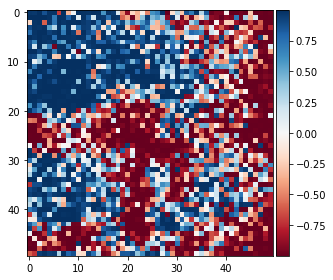

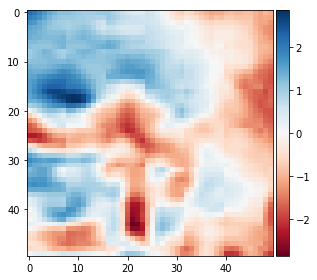

mean square error: 0.6771364


In [63]:
# In[22]:
#复原图像

# plt.figure("Image_reconstruction") # 图像窗口名称
# plt.imshow(pred_ph5.reshape(size))
# plt.axis('on') # 关掉坐标轴为 off
# plt.title('image_reconstruction') # 图像题目
# plt.show()
size=[s_h, s_w]
io.imshow(pred_ph5.reshape(size))
io.show()



# In[]
#真实图像
# plt.figure("Image_original") # 图像窗口名称
# plt.imshow(x.reshape(size))
# plt.axis('on') # 关掉坐标轴为 off
# plt.title('image_original') # 图像题目
# plt.show()

io.imshow(x.reshape(size))
io.show()


# In[24]:
def MSE(ori, rec):
    mse = 0
    for i in range(0,n):
        mse += (rec[i] - ori[i]) ** 2
    mse = np.sqrt(mse/n)
    return mse[0]

# In[25]:
#mse_dip_ph5 = MSE(x,pred_ph5)
mse_dip_ph5 = MSE(X_ph5[0,:],pred_ph5)
print('mean square error:',mse_dip_ph5)






In [ ]:
import numpy as np
def psnr(im1,im2):
    diff = numpy.abs(im1 - im2)
    rmse = numpy.sqrt(diff).sum()
    psnr = 20*numpy.log10(255/rmse)
    return psnr

x = numpy.array(pred_ph5.reshape(size))

y = numpy.array(x.reshape(size))


psnr = psnr(x,y)
print ("psnr",psnr)